## 1. 라이브러리 불러오기

In [3]:
import cv2
import mediapipe as mp
import numpy as np

## 2. Blazepose

In [14]:
# mediapipe 기능 불러오기
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 영상 파일 열기
cap = cv2.VideoCapture("../videos/attention.mp4")

# 총 프레임 개수 체크
total_frame_no = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Keypoints를 저장하기 위한 딕셔너리 초기화
keypoints_dict = {}

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    frame_num = 0
    last_valid_keypoints = None
    while cap.isOpened():
        ret, frame = cap.read()

        # 프레임이 제대로 읽혔는지 확인
        if not ret:
            break

        # 프레임의 너비와 높이 가져오기
        height, width, _ = frame.shape

        # BGR을 RGB로 변환
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 성능 향상을 위해, 참조로 전달하기 위해 이미지를 변경할 수 없음을 표시합니다.
        image.flags.writeable = False

        # MediaPipe Pose 처리
        results = pose.process(image)

        # Keypoints 가져오기
        if results.pose_landmarks:
            keypoints = results.pose_landmarks.landmark
            keypoints_dict[frame_num] = [(int(keypoints[11].x * width), int(keypoints[11].y * height)),
                                         (int(keypoints[12].x * width), int(keypoints[12].y * height))]
            last_valid_keypoints = keypoints_dict[frame_num]
        else:
            keypoints_dict[frame_num] = last_valid_keypoints  # Keypoints가 감지되지 않으면 마지막 유효한 keypoints 사용

        frame_num += 1

# 누락된 Keypoints에 대한 후처리
# 처음 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no):
    if keypoints_dict[i] is not None:
        for j in range(i):
            keypoints_dict[j] = keypoints_dict[i]
        break

# 중간에서 Keypoints가 없는 경우
start_frame = None
for i in range(total_frame_no):
    if keypoints_dict[i] is None:
        if start_frame is None:
            start_frame = i - 1
    else:
        if start_frame is not None:
            # 누락된 Keypoints에 대한 선형 보간
            start = np.array(keypoints_dict[start_frame])
            end = np.array(keypoints_dict[i])
            for j in range(start_frame + 1, i):
                keypoints_dict[j] = tuple(int(start + (end - start) * (j - start_frame) / (i - start_frame)))
            start_frame = None

# 마지막 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no - 1, -1, -1):
    if keypoints_dict[i] is not None:
        for j in range(i + 1, total_frame_no):
            keypoints_dict[j] = keypoints_dict[i]
        break

cap.release()

In [15]:
keypoints_dict

{0: [(902, 465), (1013, 454)],
 1: [(902, 465), (1013, 454)],
 2: [(902, 465), (1013, 454)],
 3: [(902, 465), (1013, 454)],
 4: [(902, 465), (1013, 454)],
 5: [(902, 465), (1013, 454)],
 6: [(902, 465), (1013, 454)],
 7: [(902, 466), (1013, 455)],
 8: [(902, 466), (1013, 455)],
 9: [(902, 466), (1013, 455)],
 10: [(902, 466), (1013, 455)],
 11: [(903, 465), (1013, 455)],
 12: [(903, 465), (1013, 455)],
 13: [(903, 465), (1014, 456)],
 14: [(903, 465), (1014, 456)],
 15: [(903, 464), (1014, 456)],
 16: [(903, 464), (1014, 456)],
 17: [(904, 464), (1014, 456)],
 18: [(904, 464), (1015, 456)],
 19: [(904, 463), (1015, 456)],
 20: [(904, 463), (1015, 456)],
 21: [(904, 463), (1016, 456)],
 22: [(904, 463), (1016, 456)],
 23: [(904, 463), (1017, 456)],
 24: [(904, 463), (1017, 456)],
 25: [(904, 463), (1017, 456)],
 26: [(904, 464), (1018, 456)],
 27: [(904, 464), (1018, 456)],
 28: [(904, 464), (1018, 456)],
 29: [(904, 464), (1018, 456)],
 30: [(904, 464), (1018, 456)],
 31: [(904, 464), 

In [22]:
# 1. x_center를 구하기 위한 함수
x_centers = []

for idx in range(len(keypoints_dict)):
    x_centers.append((keypoints_dict[idx][0][0] + keypoints_dict[idx][1][0]) // 2)

# =======================================================================================
# 2. 이동평균을 구하는 함수
def calculate_moving_average(numbers, window_size):
    moving_averages = []
    for i in range(len(numbers)):
        if i < window_size - 1:
            # If window size not reached, calculate average with available numbers
            window_sum = sum(numbers[:i+1])
            moving_averages.append(int(window_sum / (i+1)))
        else:
            window_sum = sum(numbers[i-window_size+1:i+1])
            moving_averages.append(int(window_sum / window_size))
    return moving_averages

# =======================================================================================
# 3. 30프레임 이동평균을 담은 x_centers
x_centers_movavg = calculate_moving_average(x_centers, 15)

# =======================================================================================
# 4. 프레임의 갯수 체크
print(len(x_centers))
print(len(x_centers_movavg))

3181
3181


In [23]:
# 이동평균을 구했을 때 발생하는 x_center의 최대 오차
max_diff = 0
for i in range(len(x_centers)):
    diff = abs(x_centers[i] - x_centers_movavg[i])
    if diff > max_diff:
        max_diff = diff
    
print(max_diff)

72


## 3. Movenet

In [40]:
import time
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np

# TF Hub에서 모델 MoveNet-singlepose-thunder 로드
model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
movenet = model.signatures['serving_default']

# Threshold 설정
threshold = 0.5

# 비디오 소스 로드
video_source = '../videos/attention.mp4'  # 비디오 파일 경로 지정
cam = cv2.VideoCapture(video_source)

# 비디오 캡쳐 중 오류 확인
if not cam.isOpened():
    print('Error loading video')
    quit()

fps = cam.get(cv2.CAP_PROP_FPS)  # 영상의 원래 fps 사용

success, img = cam.read()

if not success:
    print('Error reading frame')
    quit()

y, x, _ = img.shape             # (x, y) = (1920, 1080)
keypoints_dict2 = {}             # {frame_number: [(left_shoulder_x, left_shoulder_y), (right_shoulder_x, right_shoulder_y)], ...}
frame_number = 0                # 프레임 번호를 저장할 변수 초기화

while success:
    # 비디오 or 이미지 한 프레임은 int32의 tensor로 출력됨
    # shape: 192x192x3 / channel 순서와 범위: RGB, [0, 255]
    tf_img = cv2.resize(img, (192, 192))
    tf_img = cv2.cvtColor(tf_img, cv2.COLOR_BGR2RGB)
    tf_img = np.asarray(tf_img)
    tf_img = np.expand_dims(tf_img, axis=0)

    # tf_img를 정수형 데이터로 변환 -> 비율 유지하여 size를 맞추기 위해 resize & padding
    image = tf.cast(tf_img, dtype=tf.int32)

    outputs = movenet(image)                # 모델 추론
    keypoints = outputs['output_0']         # Output is a [1, 1, 17, 3] tensor

    keypoints_coordinates = []

    for k in keypoints[0, 0, :, :]:
        k = k.numpy()                       # Numpy array로 변환

        if k[2] > threshold:                # 관절이 감지되었는지 확인
            # 마지막 차원의 첫 번째 두 채널은 17개 관절의 y, x 좌표
            # (이미지 프레임에 대해 정규화된 값, 즉 [0.0, 1.0] 범위)를 나타냄
            yc = int(k[0] * y)
            xc = int(k[1] * x)
            keypoints_coordinates.append((xc, yc))
        else:
            keypoints_coordinates.append(None)

    # left_shoulder = 5, right_shoulder = 6 인덱스
    keypoints_dict2[frame_number] = (keypoints_coordinates[5], keypoints_coordinates[6])

    success, img = cam.read()
    frame_number += 1  # 프레임 번호 증가

# 누락된 Keypoints에 대한 보간
total_frame_no = frame_number

# 처음 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no):
    if keypoints_dict2[i][0] is not None and keypoints_dict2[i][1] is not None:
        for j in range(i):
            keypoints_dict2[j] = keypoints_dict2[i]
        break

# 중간에서 Keypoints가 없는 경우
start_frame = None
for i in range(total_frame_no):
    if keypoints_dict2[i][0] is None or keypoints_dict2[i][1] is None:
        if start_frame is None:
            start_frame = i - 1
    else:
        if start_frame is not None:
            # 누락된 Keypoints에 대한 선형 보간
            start = np.array(keypoints_dict2[start_frame])
            end = np.array(keypoints_dict2[i])
            for j in range(start_frame + 1, i):
                keypoints_dict2[j] = tuple((start + (end - start) * (j - start_frame) / (i - start_frame)).astype(int))
            start_frame = None

# 마지막 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no - 1, -1, -1):
    if keypoints_dict2[i][0] is not None and keypoints_dict[i][1] is not None:
        for j in range(i + 1, total_frame_no):
            keypoints_dict2[j] = keypoints_dict2[i]
        break

cam.release()


In [27]:
keypoints_dict2

{0: ((917, 450), (1018, 455)),
 1: ((917, 450), (1018, 455)),
 2: ((917, 450), (1018, 455)),
 3: ((917, 450), (1018, 455)),
 4: ((917, 450), (1018, 455)),
 5: ((917, 450), (1018, 455)),
 6: ((996, 447), (968, 448)),
 7: ((931, 448), (1013, 452)),
 8: ((959, 465), (995, 462)),
 9: ((900, 464), (1034, 467)),
 10: ((893, 467), (1047, 467)),
 11: ((895, 475), (1039, 474)),
 12: ((896, 473), (1029, 472)),
 13: ((892, 478), (1032, 473)),
 14: ((890, 479), (1036, 473)),
 15: ((888, 482), (1045, 477)),
 16: ((882, 482), (1052, 483)),
 17: ((884, 486), (1049, 480)),
 18: ((892, 497), (1056, 488)),
 19: ((890, 497), (1052, 489)),
 20: ((886, 503), (1058, 494)),
 21: ((882, 500), (1057, 498)),
 22: ((888, 499), (1053, 499)),
 23: ((888, 496), (1046, 488)),
 24: ((893, 503), (1049, 494)),
 25: ((893, 503), (1039, 496)),
 26: ((888, 499), (1045, 495)),
 27: ((886, 495), (1042, 490)),
 28: ((887, 498), (1041, 495)),
 29: ((889, 499), (1042, 494)),
 30: ((887, 496), (1036, 493)),
 31: ((883, 494), (1

---

In [29]:
# 1. x_center를 구하기 위한 함수
x_centers = []

for idx in range(len(keypoints_dict2)):
    x_centers.append((keypoints_dict2[idx][0][0] + keypoints_dict2[idx][1][0]) // 2)

# =======================================================================================
# 2. 이동평균을 구하는 함수
def calculate_moving_average(numbers, window_size):
    moving_averages = []
    for i in range(len(numbers)):
        if i < window_size - 1:
            # If window size not reached, calculate average with available numbers
            window_sum = sum(numbers[:i+1])
            moving_averages.append(int(window_sum / (i+1)))
        else:
            window_sum = sum(numbers[i-window_size+1:i+1])
            moving_averages.append(int(window_sum / window_size))
    return moving_averages

# =======================================================================================
# 3. 30프레임 이동평균을 담은 x_centers
x_centers_movavg = calculate_moving_average(x_centers, 15)

# =======================================================================================
# 4. 프레임의 갯수 체크
print(len(x_centers))
print(len(x_centers_movavg))

3181
3181


In [ ]:
# 이동평균을 구했을 때 발생하는 x_center의 최대 오차
max_diff = 0
for i in range(len(x_centers)):
    diff = abs(x_centers[i] - x_centers_movavg[i])
    if diff > max_diff:
        max_diff = diff
    
print(max_diff)

96


## 4. 결론

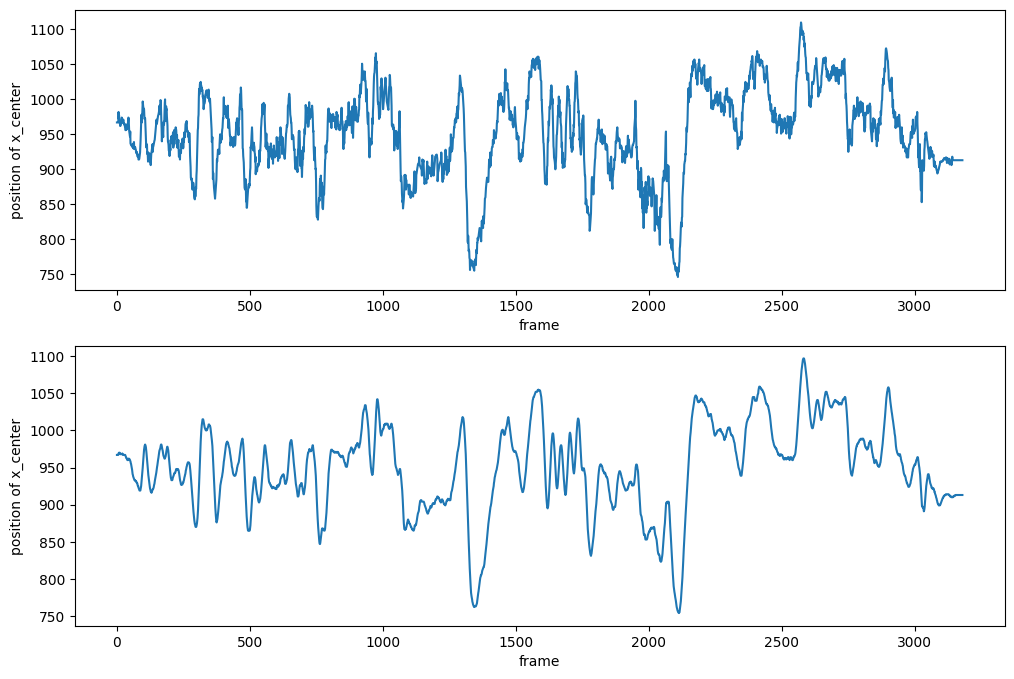

In [31]:
# 원본 x_centers와 이동평균을 구해 smoothing한 x_centers의 시각적 비교
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))


plt.subplot(2,1,1)
plt.plot(x_centers)
plt.xlabel("frame")
plt.ylabel("position of x_center")

plt.subplot(2,1,2)
plt.plot(x_centers_movavg)
plt.xlabel("frame")
plt.ylabel("position of x_center")

plt.show()

In [45]:
cap = cv2.VideoCapture("../videos/attention.mp4")

# 키포인트의 x 좌표값이 담긴 배열
x_centers = np.array(x_centers_movavg)

fourcc = cv2.VideoWriter_fourcc(*"avc1")
out = cv2.VideoWriter("../videos/attetion-movenet.mp4", fourcc, 30.0, (int(1080*(9/16)), 1080))

frame_no = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        # frame.shape = (height, width, channel)
        H, W = frame.shape[:2]
        
        # 중심점 x 좌표를 가져옵니다.
        x_center = x_centers[frame_no]
        
        # 크롭할 영역의 좌상단과 우하단 좌표를 계산합니다.
        start_x = max(0, int(x_center - (1080*(9/16))//2))
        end_x = min(W, int(x_center + (1080*(9/16))//2))
        start_y = 0
        end_y = H

        # 크롭한 영역을 가져옵니다.
        cropped_frame = frame[start_y:end_y, start_x:end_x]
        
        # 크롭한 영역의 크기를 조정합니다.
        resized_frame = cv2.resize(cropped_frame, (int(1080*(9/16)), 1080))
        
        # 결과 영상에 프레임을 씁니다.
        out.write(resized_frame)

        frame_no += 1
    else:
        break

cap.release()
out.release()